# Data Preprocessing
RSNA Intracranial Hemorrhage Detection
* Create dataset for pytorch models with dicom images
* Normalize, transform

Preprocessing to-do:
- ~~Train/Validation/Test split~~
    - ~~Make sure to keep class distribution~~
    - ~~Split by patient, not image~~
    
* ~~Create random smaller subsets to get the model working~~
    - ~~Class distribution, split by patient~~
    - ~~Maybe try first with ~200 training? ~~
    - ~~Once debugged, scale up to 1000, 10000, whole dataset~~   
   
* ~~3 channel windowing~~
    - using brain, subdural, soft tissue right now
    - consider using bone window instead of soft tissue

* ~~Transformations/data augmentation~~
    - ~~random horizontal flip~~
    - ~~random vertical flip~~
    - ~~random rotate (should be able to fill empty space with black)~~
    - ~~tensor~~
    - ~~normalize~~
    - ~~resize? Depends on model I think~~
    - If needed, could also try:
        - random noise
    - If there is class imbalance problem, also consider over-/undersampling
        - this might not be necessary if use weighted loss
        
* ~~Create DataLoader~~

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import PIL
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import time
from sklearn.model_selection import train_test_split, GroupShuffleSplit

In [2]:
# set global path and device
dpath = '/rsna-intracranial-hemorrhage-detection/'
trpath = '/rsna-intracranial-hemorrhage-detection/stage_2_train/'

if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Label Dataframe(s)

In [3]:
# Reshape and add patient IDs
def reshape_df(df_path): 
    # Reshape
    df = pd.read_csv(df_path)
    df['Image ID'] = df['ID'].str[:12]
    df['subtype'] = df['ID'].str[13:]
    df = df.drop(['ID'], axis=1)
    df = df.pivot_table(index=['Image ID'], columns='subtype', values='Label').reset_index().rename_axis(None, axis=1)
    # Get patient IDs from dicom files
    id_dict = {}
    since = time.time()
    for i in list(df['Image ID']):
        img_dcm = pydicom.dcmread(trpath + i + '.dcm')
        pat_id = str(img_dcm.PatientID)
        id_dict[i] = pat_id
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    df['Patient ID'] = df['Image ID'].map(id_dict)
    
    df = df[['Image ID', 'Patient ID', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']]
    
    return df

# 'reshape_df' function takes FOREVER. Only run the below once and then save csv until able to optimize
# labs_df_path = dpath + 'stage_2_train.csv'
# df_labs = reshape_df(labs_df_path) 
# df_labs.to_csv('./data/stage_2_train_reshaped.csv', index=False)

In [4]:
df_labs = pd.read_csv('./data/stage_2_train_reshaped.csv')
print('Unique patients: ', len(df_labs['Patient ID'].unique()))
df_labs

Unique patients:  18938


,Image ID,Patient ID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any
0,ID_000012eaf,ID_f15c0eee,0,0,0,0,0,0
1,ID_000039fa0,ID_eeaf99e7,0,0,0,0,0,0
2,ID_00005679d,ID_18f2d431,0,0,0,0,0,0
3,ID_00008ce3c,ID_ce8a3cd2,0,0,0,0,0,0
4,ID_0000950d7,ID_d278c67b,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
752798,ID_ffff82e46,ID_a85c9d08,0,0,0,0,0,0
752799,ID_ffff922b9,ID_5964c5e5,0,0,1,0,0,1
752800,ID_ffffb670a,ID_4f7414e4,0,0,0,1,0,1
752801,ID_ffffcbff8,ID_a5382712,0,0,0,0,0,0


In [7]:
# subclass counts
for i in ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']:
    print(i, df_labs[i].sum(), ', ', df_labs[i].sum()/len(df_labs))

epidural 3145 ,  0.004177719801860514
intraparenchymal 36118 ,  0.0479780234669628
intraventricular 26205 ,  0.03480990378624952
subarachnoid 35675 ,  0.04738955609900598
subdural 47166 ,  0.06265384170891987
any 107933 ,  0.14337482714601296


Split data into train, validate, and test by patient ID 

In [13]:
# Create group splitters
gss_val = GroupShuffleSplit(n_splits=1, train_size=0.85, random_state=8)
gss_test = GroupShuffleSplit(n_splits=1, train_size=0.65/0.85, random_state=8)
    # Validation set
for train_idx, val_idx in gss_val.split(X=df_labs, y=None, groups=df_labs['Patient ID']):
    df_temp = df_labs.iloc[train_idx].reset_index().drop('index', axis=1)
    df_val = df_labs.iloc[val_idx].reset_index().drop('index', axis=1)

    # Train and test set
for train_idx, test_idx in gss_test.split(X=df_temp, y=None, groups=df_temp['Patient ID']):
    df_train = df_temp.iloc[train_idx].reset_index().drop('index', axis=1)
    df_test = df_temp.iloc[test_idx].reset_index().drop('index', axis=1)

# Remove corrupted file from test set
df_test = df_test[df_test['Image ID'] != 'ID_6431af929']
    
print('train obs: ', len(df_train), 'val obs: ', len(df_val), 'test obs: ', len(df_test), '\n')

# Check class distribution
train = [] 
validation = []
test = []
for i in ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']:
    print(' Train % {}: '.format(i), '{:.2%}'.format(df_train[i].sum() / len(df_train)), '\n',
          'Validation % {}: '.format(i), '{:.2%}'.format(df_val[i].sum() / len(df_val)), '\n',
          'Test % {}: '.format(i), '{:.2%}'.format(df_test[i].sum() / len(df_test)), '\n')
    
    train.append(round((df_train[i].sum() / len(df_train))*100,1))
    validation.append(round((df_val[i].sum() / len(df_val))*100,1))
    test.append(round((df_test[i].sum() / len(df_test))*100,1))
    # Dataset seems to be large enough that class distribution is reasonably well balanced. 
    # Potentially stratify if results indicate that it's necessary.
    
# Export train and test data to csv
df_train.to_csv('./data/df_train.csv', index=False)
df_val.to_csv('./data/df_val.csv', index=False)
df_test.to_csv('./data/df_test.csv', index=False)

train obs:  490702 val obs:  112779 test obs:  149321 

 Train % epidural:  0.43% 
 Validation % epidural:  0.39% 
 Test % epidural:  0.38% 

 Train % intraparenchymal:  4.78% 
 Validation % intraparenchymal:  4.87% 
 Test % intraparenchymal:  4.79% 

 Train % intraventricular:  3.45% 
 Validation % intraventricular:  3.30% 
 Test % intraventricular:  3.71% 

 Train % subarachnoid:  4.68% 
 Validation % subarachnoid:  4.88% 
 Test % subarachnoid:  4.81% 

 Train % subdural:  6.11% 
 Validation % subdural:  6.71% 
 Test % subdural:  6.45% 

 Train % any:  14.24% 
 Validation % any:  14.40% 
 Test % any:  14.61% 



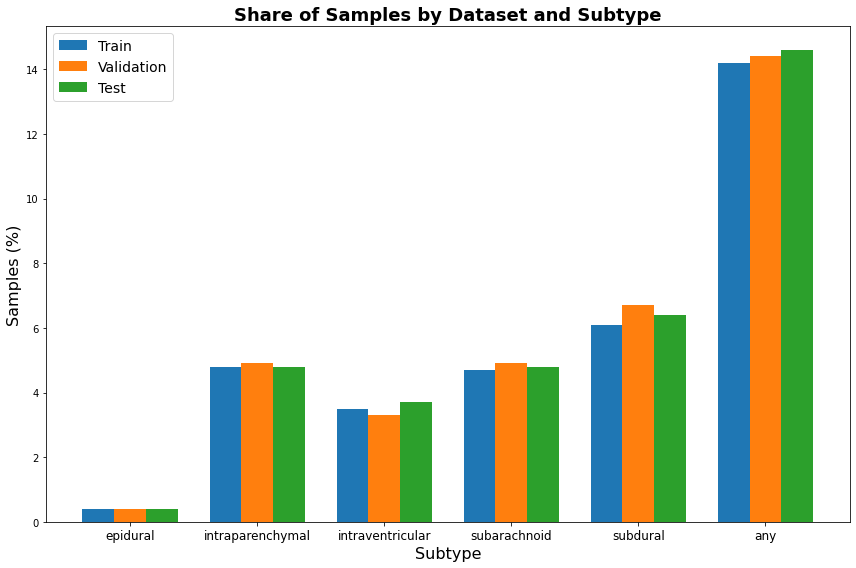

In [14]:
labels = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
x = np.arange(len(labels))
width=0.25

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width, train, width, label='Train')
rects2 = ax.bar(x, validation, width, label='Validation')
rects3 = ax.bar(x + width, test, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Samples (%)', fontsize=16)
ax.set_xlabel('Subtype', fontsize=16)
ax.set_title('Share of Samples by Dataset and Subtype', fontsize=18, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=14)

# ax.bar_label(rects1, padding=1, fontsize=12)
# ax.bar_label(rects2, padding=1, fontsize=12)
# ax.bar_label(rects3, padding=1, fontsize=12)

fig.tight_layout()
# plt.savefig('./figs/tvtsplit.png')
plt.show()

Create data subsets for model tuning/debugging

In [15]:
df = pd.read_csv('./data/df_train.csv')
_ , tr_random = train_test_split(df, test_size=0.01, random_state=33)
tr_random.to_csv('./data/train_sub.csv',index=False)
print('train obs: ', len(tr_random))

df = pd.read_csv('./data/df_val.csv')
_ , val_random = train_test_split(df, test_size=0.01, random_state=33)
val_random.to_csv('./data/val_sub.csv',index=False)
print('val obs: ', len(val_random))

# Check class distribution
for i in ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']:
    print(' Train % {}: '.format(i), '{:.2%}'.format(tr_random[i].sum() / len(tr_random)), '\n',
          'Validation % {}: '.format(i), '{:.2%}'.format(val_random[i].sum() / len(val_random)), '\n')
    # Seems good enough. Just for debugging

train obs:  4908
val obs:  1128
 Train % epidural:  0.51% 
 Validation % epidural:  0.44% 

 Train % intraparenchymal:  4.26% 
 Validation % intraparenchymal:  5.67% 

 Train % intraventricular:  3.63% 
 Validation % intraventricular:  2.84% 

 Train % subarachnoid:  4.79% 
 Validation % subarachnoid:  5.41% 

 Train % subdural:  5.97% 
 Validation % subdural:  5.67% 

 Train % any:  13.67% 
 Validation % any:  14.10% 



Image Dataset Class

In [16]:
# Define windowing functions
def window(img, center, width):
    img = img.copy()
    img_min = center - width // 2
    img_max = center + width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    return img

def window_levels(img):
    image1 = window(img, 40, 80) # brain
    image2 = window(img, 80, 200) # subdural
    image3 = window(img, 40, 380) # soft tissue
    image1 = (image1 - 0) / 80
    image2 = (image2 - (-20)) / 200
    image3 = (image3 - (-150)) / 380
    img = np.array([
        image1 - image1.mean(),
        image2 - image2.mean(),
        image3 - image3.mean(),
    ]).transpose(1,2,0)

    return img

# CT windowing sources
    # https://www.stepwards.com/?page_id=21646
    # https://radiopaedia.org/articles/windowing-ct?lang=us
    # https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing
    # https://www.kaggle.com/allunia/rsna-ih-detection-eda

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([0, 0, 0, 0, 0, 0])
ID_000039fa0


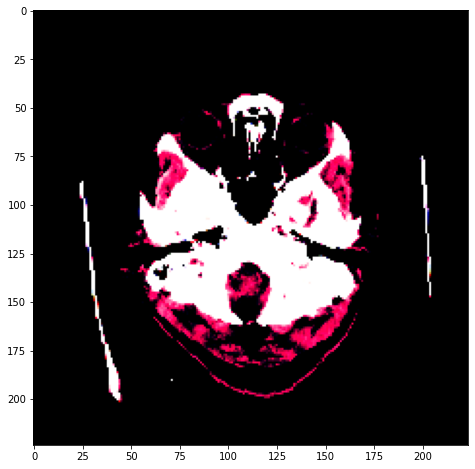

In [17]:
# Transforms, may need to copy into train script
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)), # not sure if need resize
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.Normalize([0.456, 0.456, 0.456], [0.224, 0.224, 0.224])
        ])

val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)), # not sure if need resize
        transforms.Normalize([0.456, 0.456, 0.456], [0.224, 0.224, 0.224])
        ])

# Dataset class, 3 channel
class RSNADataset_3chan(Dataset):
    """
    RSNA Intracranial Hemorrhage Dataset from: https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/data
    Using 3 channel windowing
    """
    def __init__(self, csv_file, root_dir, transform=None):
        """Args:
            csv_file (string): Path to csv with image IDs and labels
            root_dir (string): Directory with images
            transform (callable, optional): Optional transform to be applied to sample
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_dcm = pydicom.dcmread(self.root_dir + self.data_frame.iloc[idx, 0] + '.dcm')
        img_id = str(img_dcm.SOPInstanceUID)
        img_raw = img_dcm.pixel_array

        # Image window data
        ##### slope
        if type(img_dcm.RescaleSlope) == pydicom.multival.MultiValue:
            slope = int(img_dcm.RescaleSlope[0])
        else:
            slope = int(img_dcm.RescaleSlope)
        ##### intercept
        if type(img_dcm.RescaleIntercept) == pydicom.multival.MultiValue:
            intercept = int(img_dcm.RescaleIntercept[0])
        else:
            intercept = int(img_dcm.RescaleIntercept)
        ##### center
        if type(img_dcm.WindowCenter) == pydicom.multival.MultiValue:
            center = int(img_dcm.WindowCenter[0])
        else:
            center = int(img_dcm.WindowCenter)  
        ##### width
        if type(img_dcm.WindowWidth) == pydicom.multival.MultiValue:
            width = int(img_dcm.WindowWidth[0])
        else:
            width = int(img_dcm.WindowWidth) 

        # Window image
        img = img_raw * slope + intercept
        img = window_levels(img)

        # Normalize
        min_im = np.min(img)
        max_im = np.max(img)
        img = ((img - min_im) / (max_im - min_im + 1e-4))
        
        # Transforms
        if self.transform:
            img = self.transform(img)
        
        # Get label (one-hot, but really two-hot)
        label = self.data_frame.loc[idx,'epidural':'any'].to_numpy().astype(float)
        
        # To tensors
        label = torch.tensor(label).long()
        
        sample = {'image':img, 'class':label, 'img_id':img_id}
        
        return sample

# Make sure it works
labs_df_path = './data/stage_2_train_reshaped.csv'

sample = RSNADataset_3chan(labs_df_path, trpath, transform=train_transform)

im_ind = 1
print(sample[im_ind]['image'].shape)
print(sample[im_ind]['class'])
print(sample[im_ind]['img_id'])

plt.figure(figsize=(8,8))
plt.imshow(np.moveaxis(sample[im_ind]['image'].numpy(), 0, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([0, 0, 0, 0, 0, 0])
ID_000039fa0


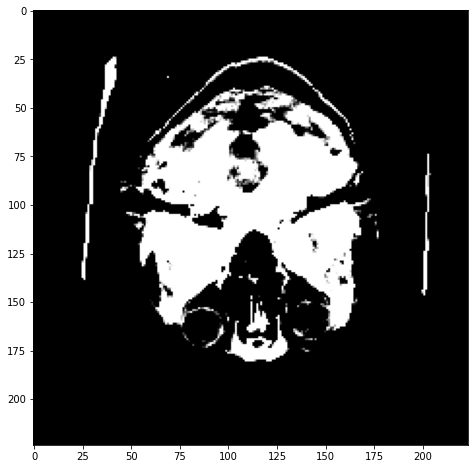

In [18]:
# Dataset class, 1 channel
class RSNADataset_1chan(Dataset):
    """
    RSNA Intracranial Hemorrhage Dataset from: https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/data
    Using 3 channel windowing
    """
    def __init__(self, csv_file, root_dir, transform=None):
        """Args:
            csv_file (string): Path to csv with image IDs and labels
            root_dir (string): Directory with images
            transform (callable, optional): Optional transform to be applied to sample
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_dcm = pydicom.dcmread(self.root_dir + self.data_frame.iloc[idx, 0] + '.dcm')
        img_id = str(img_dcm.SOPInstanceUID)
        img_raw = img_dcm.pixel_array

        # Image window data
        ##### slope
        if type(img_dcm.RescaleSlope) == pydicom.multival.MultiValue:
            slope = int(img_dcm.RescaleSlope[0])
        else:
            slope = int(img_dcm.RescaleSlope)
        ##### intercept
        if type(img_dcm.RescaleIntercept) == pydicom.multival.MultiValue:
            intercept = int(img_dcm.RescaleIntercept[0])
        else:
            intercept = int(img_dcm.RescaleIntercept)
        ##### center
        if type(img_dcm.WindowCenter) == pydicom.multival.MultiValue:
            center = int(img_dcm.WindowCenter[0])
        else:
            center = int(img_dcm.WindowCenter)  
        ##### width
        if type(img_dcm.WindowWidth) == pydicom.multival.MultiValue:
            width = int(img_dcm.WindowWidth[0])
        else:
            width = int(img_dcm.WindowWidth) 

        # Window image
        img = img_raw * slope + intercept
        img = window(img, center, width)

        # Normalize
        min_im = np.min(img)
        max_im = np.max(img)
        img = ((img - min_im) / (max_im - min_im + 1e-4))
        
        # Transforms
        img = np.expand_dims(img, axis=2)
        img = np.tile(img, (1, 1, 3)) # make 3 chan
        if self.transform:
            img = self.transform(img)
        
        # Get label (one-hot, but really two-hot)
        label = self.data_frame.loc[idx,'epidural':'any'].to_numpy().astype(float)
        
        # To tensors
        label = torch.tensor(label).long()
        
        sample = {'image':img, 'class':label, 'img_id':img_id}
        
        return sample

# Make sure it works
labs_df_path = './data/stage_2_train_reshaped.csv'

sample = RSNADataset_1chan(labs_df_path, trpath, transform=train_transform)

im_ind = 1
print(sample[im_ind]['image'].shape)
print(sample[im_ind]['class'])
print(sample[im_ind]['img_id'])

plt.figure(figsize=(8,8))
plt.imshow(np.moveaxis(sample[im_ind]['image'].numpy(), 0, 2))

Create Dataloader

In [19]:
# Dataloader, copy into train script
train_df_path = './data/df_train.csv'
val_df_path = './data/df_val.csv'
test_df_path = './data/df_test.csv'
transformed_dataset = {'train':RSNADataset_3chan(train_df_path, trpath, transform=train_transform),
                       'validate':RSNADataset_3chan(val_df_path, trpath, transform=val_transform),
                       'test':RSNADataset_3chan(test_df_path, trpath, transform=val_transform),
                                          }
bs = 5

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                            shuffle=True, num_workers=0) for x in ['train', 'validate']}

dataloader['test'] = DataLoader(transformed_dataset['test'], batch_size=bs,
                                shuffle=False, num_workers=0)
data_sizes = {x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [20]:
pydicom.dcmread(trpath + 'ID_000039fa0.dcm')

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.4267.32.162913613590029796866673494045672074853
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_000039fa0
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_eeaf99e7'
(0020, 000d) Study Instance UID                  UI: ID_134d398b61
(0020, 000e) Series Instance UID                 UI: ID_5f8484c3e0
(0020, 0010) Study ID                            SH: '